In [6]:

num_clients = 30
distribution_type = 'random_iid'  # Can also be 'random' for non-IID distribution
root_percentage = 0.1  # Define the percentage of the dataset to use for the root client


# Split into Dist

In [2]:
import os
import struct
import numpy as np

def load_mnist(path, kind='train'):
    """Load MNIST data from `path`."""
    labels_path = os.path.join(path, f'{kind}-labels.idx1-ubyte')
    images_path = os.path.join(path, f'{kind}-images.idx3-ubyte')

    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack('>IIII', imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)

    return images, labels

# Path to the directory containing the ubyte files
mnist_path = 'mnist'

# Load training and test data
x_train, y_train = load_mnist(mnist_path, kind='train')
x_test, y_test = load_mnist(mnist_path, kind='t10k')

# Optionally, split the training data into training and validation sets
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=10000, random_state=42)

# Reshape images to 28x28 if necessary
x_train = x_train.reshape(-1, 28, 28, 1)
x_valid = x_valid.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

print("Training data:", x_train.shape, y_train.shape)
print("Validation data:", x_valid.shape, y_valid.shape)
print("Test data:", x_test.shape, y_test.shape)

Training data: (50000, 28, 28, 1) (50000,)
Validation data: (10000, 28, 28, 1) (10000,)
Test data: (10000, 28, 28, 1) (10000,)


New

Root data saved: dataset/root/x_data.npy, dataset/root/y_data.npy
Client 1 data saved: dataset/client_1/x_data.npy, dataset/client_1/y_data.npy
Client 2 data saved: dataset/client_2/x_data.npy, dataset/client_2/y_data.npy
Client 3 data saved: dataset/client_3/x_data.npy, dataset/client_3/y_data.npy
Client 4 data saved: dataset/client_4/x_data.npy, dataset/client_4/y_data.npy
Client 5 data saved: dataset/client_5/x_data.npy, dataset/client_5/y_data.npy
Client 6 data saved: dataset/client_6/x_data.npy, dataset/client_6/y_data.npy
Client 7 data saved: dataset/client_7/x_data.npy, dataset/client_7/y_data.npy
Client 8 data saved: dataset/client_8/x_data.npy, dataset/client_8/y_data.npy
Client 9 data saved: dataset/client_9/x_data.npy, dataset/client_9/y_data.npy
Client 10 data saved: dataset/client_10/x_data.npy, dataset/client_10/y_data.npy
Client 11 data saved: dataset/client_11/x_data.npy, dataset/client_11/y_data.npy
Client 12 data saved: dataset/client_12/x_data.npy, dataset/client_12/

/var/folders/k8/v02rcpmj2bv13wz_w7qm_tdh0000gn/T/ipykernel_58311/584435497.py:120: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10')  # Use 'tab10' colormap for up to 10 distinct colors
/var/folders/k8/v02rcpmj2bv13wz_w7qm_tdh0000gn/T/ipykernel_58311/584435497.py:120: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10')  # Use 'tab10' colormap for up to 10 distinct colors


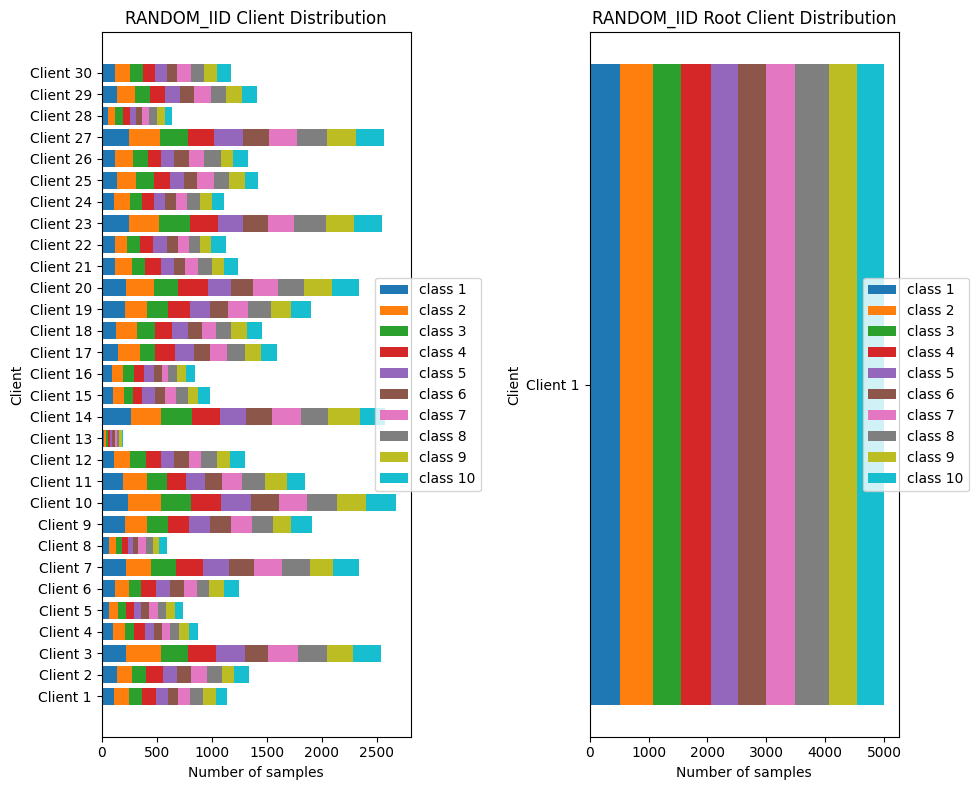

In [7]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt

class FederatedDataSplitter:
    def __init__(self, x_train, y_train, x_test, y_test, num_clients=10, distribution='iid', root_size=0.2, dataset_dir='dataset'):
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.num_clients = num_clients
        self.distribution = distribution
        self.root_size = root_size
        self.dataset_dir = dataset_dir
        self.client_distributions = []
        self.root_distribution = []

    def split_data(self):
        # Ensure the dataset directory exists
        os.makedirs(self.dataset_dir, exist_ok=True)

        # Split off root data
        root_data_size = int(len(self.x_train) * self.root_size)
        x_root = self.x_train[:root_data_size]
        y_root = self.y_train[:root_data_size]
        x_train_clients = self.x_train[root_data_size:]
        y_train_clients = self.y_train[root_data_size:]

        # Save root data
        self.save_root_data(x_root, y_root)
        
        # Track root class distribution
        self.root_distribution = np.bincount(y_root, minlength=10)

        # Split remaining data across clients
        if self.distribution == 'iid':
            split_sizes = [len(x_train_clients) // self.num_clients] * self.num_clients
        elif self.distribution == 'random_iid':
            # Random IID: Clients get random-sized splits of the data
            split_sizes = [random.randint(1, len(x_train_clients) // 2) for _ in range(self.num_clients)]
            total_size = sum(split_sizes)
            split_sizes = [int(size / total_size * len(x_train_clients)) for size in split_sizes]

        # Ensure all data is assigned
        if sum(split_sizes) != len(x_train_clients):
            split_sizes[-1] += len(x_train_clients) - sum(split_sizes)

        start_idx = 0
        for i in range(self.num_clients):
            end_idx = start_idx + split_sizes[i]
            x_client = x_train_clients[start_idx:end_idx]
            y_client = y_train_clients[start_idx:end_idx]
            start_idx = end_idx

            # Save client data
            self.save_client_data(x_client, y_client, client_id=i+1)
            
            # Track class distribution for each client
            client_distribution = np.bincount(y_client, minlength=10)
            self.client_distributions.append(client_distribution)

        # Save test data
        self.save_test_data()

    def save_client_data(self, x_client, y_client, client_id):
        # Create directories for each client
        client_dir = os.path.join(self.dataset_dir, f'client_{client_id}')
        os.makedirs(client_dir, exist_ok=True)

        # Save data as numpy files
        np.save(os.path.join(client_dir, 'x_data.npy'), x_client)
        np.save(os.path.join(client_dir, 'y_data.npy'), y_client)

        print(f"Client {client_id} data saved: {client_dir}/x_data.npy, {client_dir}/y_data.npy")

    def save_test_data(self):
        # Save test data in a separate directory
        test_dir = os.path.join(self.dataset_dir, 'test')
        os.makedirs(test_dir, exist_ok=True)

        np.save(os.path.join(test_dir, 'x_test.npy'), self.x_test)
        np.save(os.path.join(test_dir, 'y_test.npy'), self.y_test)

        print(f"Test data saved: {test_dir}/x_test.npy, {test_dir}/y_test.npy")

    def save_root_data(self, x_root, y_root):
        # Save root data in a separate directory
        root_dir = os.path.join(self.dataset_dir, 'root')
        os.makedirs(root_dir, exist_ok=True)

        np.save(os.path.join(root_dir, 'x_data.npy'), x_root)
        np.save(os.path.join(root_dir, 'y_data.npy'), y_root)

        print(f"Root data saved: {root_dir}/x_data.npy, {root_dir}/y_data.npy")

    @staticmethod
    def plot_distributions(client_dist, root_dist, num_clients, title):
        """Plot the class distributions of clients and the root client."""
        plt.figure(figsize=(10, 8))

        # Plot client distribution
        plt.subplot(1, 2, 1)
        FederatedDataSplitter.plot_sample_stats(client_dist, num_clients)
        plt.title(f'{title} Client Distribution')

        # Plot root client distribution
        plt.subplot(1, 2, 2)
        FederatedDataSplitter.plot_sample_stats(root_dist, 1)
        plt.title(f'{title} Root Client Distribution')

        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_sample_stats(dist, num_clients):
        """Plot the sample statistics for each client."""
        
        # Use the same color scheme ('tab10') for both root and client distributions
        colors = plt.cm.get_cmap('tab10')  # Use 'tab10' colormap for up to 10 distinct colors
        
        # If it's a single client (root client), handle it differently
        if num_clients == 1:
            classes = [f'class {i+1}' for i in range(len(dist))]
            left = 0  # Start with 0 for a single bar

            # Plot each class with a different color (reuse tab10)
            for i in range(len(classes)):
                plt.barh(0, dist[i], left=left, color=colors(i), label=classes[i])
                left += dist[i]  # Accumulate values to stack bars properly

        else:
            # For multiple clients, use dist[0] for class size
            classes = [f'class {i+1}' for i in range(len(dist[0]))]
            left = np.zeros(num_clients)  # Initialize left with zeros for clients

            # Plot each class with the same color scheme used in root (tab10)
            for i in range(len(classes)):
                plt.barh(range(num_clients), [dist[j][i] for j in range(num_clients)], 
                        left=left, color=colors(i), label=classes[i])
                left += [dist[j][i] for j in range(num_clients)]  # Accumulate values to stack bars properly

        # Add legend and labels
        plt.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))
        plt.yticks(range(num_clients), [f'Client {i+1}' for i in range(num_clients)])
        plt.xlabel('Number of samples')
        plt.ylabel('Client')





splitter = FederatedDataSplitter(x_train, y_train, x_test, y_test,
                                num_clients=num_clients, 
                                root_size=root_percentage, 
                                dataset_dir='dataset',
                                distribution=distribution_type)

splitter.split_data()

# Plot the distributions
splitter.plot_distributions(splitter.client_distributions, splitter.root_distribution, splitter.num_clients, splitter.distribution.upper())


# old method (avoid)

Root client data saved in 'dataset/root_client'.
Data for each client saved in 'dataset/clients' using IID distribution.


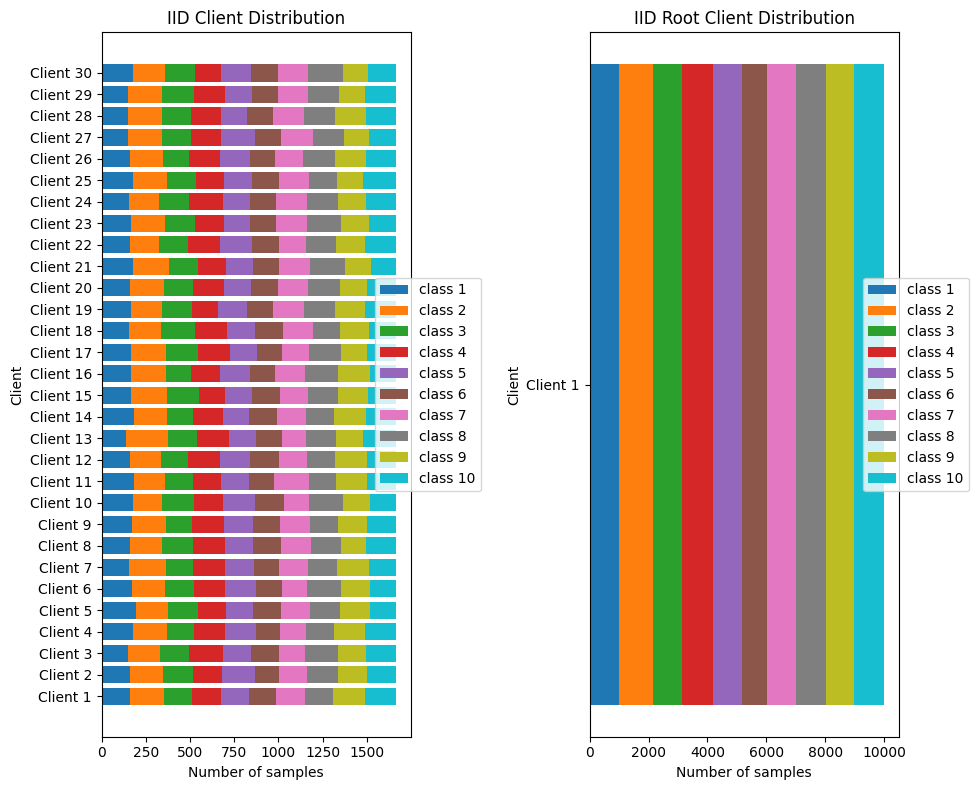

In [54]:
import os
import numpy as np
import torch
import random
import matplotlib.pyplot as plt

class DataSplitter:
    def __init__(self, x_data, y_data, num_clients, distribution='iid'):
        self.x_data = x_data
        self.y_data = y_data
        self.num_clients = num_clients
        self.distribution = distribution

    def compute_class_distributions(self, client_data, num_classes=10):
        """Compute class distributions for a set of client data."""
        distributions = []
        for x_client, y_client in client_data:
            class_counts = np.bincount(y_client, minlength=num_classes)
            distributions.append(class_counts)
        return np.array(distributions).T  # Transpose to get a list of class-wise distributions

    def create_client_splits(self):
        """Create dataset splits (IID or random) for clients."""
        client_data = []
        num_samples = len(self.x_data)
        indices = list(range(num_samples))

        if self.distribution == 'iid':
            # IID split: each client gets an equal share of the data per class
            random.shuffle(indices)
            split_size = num_samples // self.num_clients
            for i in range(self.num_clients):
                start_idx = i * split_size
                end_idx = (i + 1) * split_size
                client_indices = indices[start_idx:end_idx]
                client_data.append((self.x_data[client_indices], self.y_data[client_indices]))
        else:
            # Non-IID split: Random class assignment per client
            unique_classes = np.unique(self.y_data)
            class_indices = {cls: np.where(self.y_data == cls)[0].tolist() for cls in unique_classes}

            for i in range(self.num_clients):
                client_indices = []
                for cls in unique_classes:
                    num_class_samples = random.randint(0, len(class_indices[cls]) // self.num_clients)
                    selected_indices = random.sample(class_indices[cls], num_class_samples)
                    client_indices.extend(selected_indices)
                    class_indices[cls] = list(set(class_indices[cls]) - set(selected_indices))
                client_data.append((self.x_data[client_indices], self.y_data[client_indices]))

        return client_data

    def save_client_data(self, client_data, save_dir):
        """Save the split data for each client."""
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

        for i, (x_client, y_client) in enumerate(client_data):
            client_dir = os.path.join(save_dir, f'client_{i+1}')
            if not os.path.exists(client_dir):
                os.makedirs(client_dir)
            np.save(os.path.join(client_dir, 'x_data.npy'), x_client)
            np.save(os.path.join(client_dir, 'y_data.npy'), y_client)
        print(f"Data for each client saved in '{save_dir}' using {self.distribution.upper()} distribution.")

    def save_root_client_data(self, x_root, y_root, save_dir):
        """Save root client data."""
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        np.save(os.path.join(save_dir, 'x_data.npy'), x_root)
        np.save(os.path.join(save_dir, 'y_data.npy'), y_root)
        print(f"Root client data saved in '{save_dir}'.")

    def create_root_split(self, root_percentage=0.2, citizen=False):
        """Split the root client data or select a random client's data as the root (citizen mode)."""
        if citizen:
            client_data = self.create_client_splits()
            random_client_idx = random.randint(0, self.num_clients - 1)
            x_root, y_root = client_data[random_client_idx]
            print(f"Selected client {random_client_idx + 1} as the root dataset (citizen mode).")
        else:
            # Standard root split with a percentage of the full dataset
            num_samples = len(self.x_data)
            indices = list(range(num_samples))
            random.shuffle(indices)
            root_size = int(root_percentage * num_samples)
            root_indices = indices[:root_size]
            x_root = self.x_data[root_indices]
            y_root = self.y_data[root_indices]
        return x_root, y_root

    def create_and_save_splits(self, root_percentage=0.2, citizen=False):
        """Create and save data splits for root client and other clients."""
        # Create root split
        x_root, y_root = self.create_root_split(root_percentage=root_percentage, citizen=citizen)
        self.save_root_client_data(x_root, y_root, 'dataset/root_client')

        # Create dataset splits for other clients
        client_data = self.create_client_splits()
        self.save_client_data(client_data, 'dataset/clients')

        # Compute class distributions for visualization
        return self.compute_class_distributions(client_data), self.compute_class_distributions([(x_root, y_root)])

    @staticmethod
    def plot_distributions(client_dist, root_dist, num_clients, title):
        """Plot the class distributions of clients and the root client."""
        plt.figure(figsize=(10, 8))

        # Plot client distribution
        plt.subplot(1, 2, 1)
        DataSplitter.plot_sample_stats(client_dist, num_clients)
        plt.title(f'{title} Client Distribution')

        # Plot root client distribution
        plt.subplot(1, 2, 2)
        DataSplitter.plot_sample_stats(root_dist, 1)
        plt.title(f'{title} Root Client Distribution')

        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_sample_stats(dist, num_clients):
        """Plot the sample statistics for each client."""
        classes = [f'class {i+1}' for i in range(len(dist))]
        for i in range(len(classes)):
            left = sum(dist[j][:num_clients] for j in range(i))
            plt.barh(range(num_clients), dist[i][:num_clients], left=left, label=classes[i])
        plt.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))
        plt.yticks(range(num_clients), [f'Client {i+1}' for i in range(num_clients)])
        plt.xlabel('Number of samples')
        plt.ylabel('Client')

x_train_numpy = x_train
y_train_numpy = y_train

splitter = DataSplitter(x_train_numpy, y_train_numpy, num_clients, distribution=distribution_type)
client_distributions, root_distribution = splitter.create_and_save_splits(root_percentage=root_percentage, citizen=False)
splitter.plot_distributions(client_distributions, root_distribution, num_clients, distribution_type.upper())

Visualise Clients

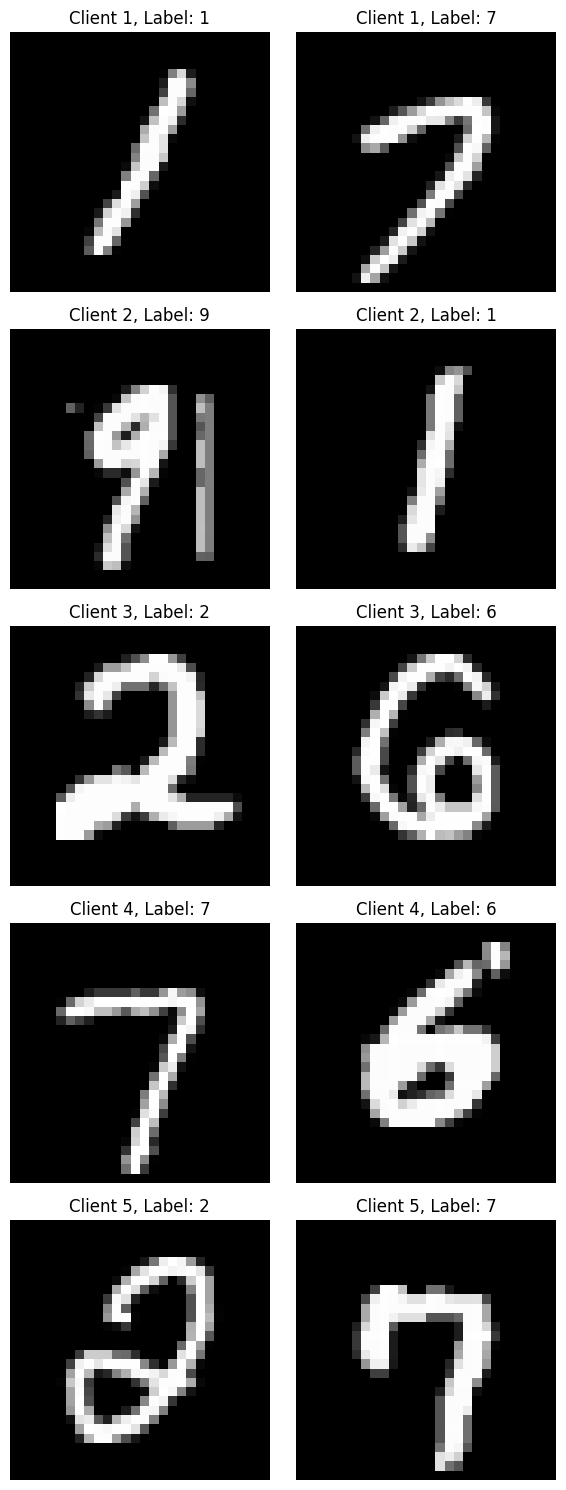

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import os

def load_client_data(client_dir):
    """Load the saved client data from the client directory."""
    x_data = np.load(os.path.join(client_dir, 'x_data.npy'))
    y_data = np.load(os.path.join(client_dir, 'y_data.npy'))
    return x_data, y_data

def visualize_samples_from_clients(num_clients=10, num_samples=2):
    """Visualize 2 samples from each client alongside their labels."""
    client_base_dir = 'dataset/clients'
    
    plt.figure(figsize=(num_samples * 3, num_clients * 3))  # Adjust figure size for multiple images
    
    for client_idx in range(1, num_clients + 1):
        client_dir = os.path.join(client_base_dir, f'client_{client_idx}')
        x_client, y_client = load_client_data(client_dir)
        
        # Select the first `num_samples` images from the client dataset
        for i in range(num_samples):
            plt.subplot(num_clients, num_samples, client_idx * num_samples - num_samples + i + 1)
            plt.imshow(x_client[i].squeeze(), cmap='gray')  # Use .squeeze() to remove singleton dimensions if needed
            plt.title(f'Client {client_idx}, Label: {y_client[i]}')
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage:
num_clients = 5 # Number of clients
num_samples = 2   # Number of samples to visualize per client
visualize_samples_from_clients(num_clients=num_clients, num_samples=num_samples)

Test Splitting and Visualisation

In [56]:
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import struct

# Utility to load MNIST images and labels
def load_mnist_images(filename):
    """Load MNIST images from an idx3-ubyte file."""
    with open(filename, 'rb') as f:
        magic, num_images, rows, cols = struct.unpack(">IIII", f.read(16))
        images = np.fromfile(f, dtype=np.uint8).reshape(num_images, 1, rows, cols)
        return images / 255.0  # Normalize the pixel values to [0, 1]

def load_mnist_labels(filename):
    """Load MNIST labels from an idx1-ubyte file."""
    with open(filename, 'rb') as f:
        magic, num_labels = struct.unpack(">II", f.read(8))
        labels = np.fromfile(f, dtype=np.uint8)
        return labels

# Function to store the test data in 'dataset/test'
def store_test_data():
    test_images = load_mnist_images('mnist/t10k-images.idx3-ubyte')
    test_labels = load_mnist_labels('mnist/t10k-labels.idx1-ubyte')
    
    test_save_dir = 'dataset/test'
    if not os.path.exists(test_save_dir):
        os.makedirs(test_save_dir)
    
    np.save(os.path.join(test_save_dir, 'x_test.npy'), test_images)
    np.save(os.path.join(test_save_dir, 'y_test.npy'), test_labels)
    
    print(f"Test data saved in '{test_save_dir}'.")

# Class to create a test DataLoader similar to client DataLoader


# Usage Example:

# 1. Store the test data in 'dataset/test' directory
store_test_data()

# 2. Create and retrieve the test DataLoader
test_loader_instance = TestDataLoader(batch_size=64)
test_loader = test_loader_instance.get_test_loader()

# To verify, let's print out a batch of test data:
for images, labels in test_loader:
    print(f"Batch of test images: {images.shape}")
    print(f"Batch of test labels: {labels.shape}")
    break  # Just checking the first batch

Test data saved in 'dataset/test'.
Batch of test images: torch.Size([64, 1, 28, 28])
Batch of test labels: torch.Size([64])


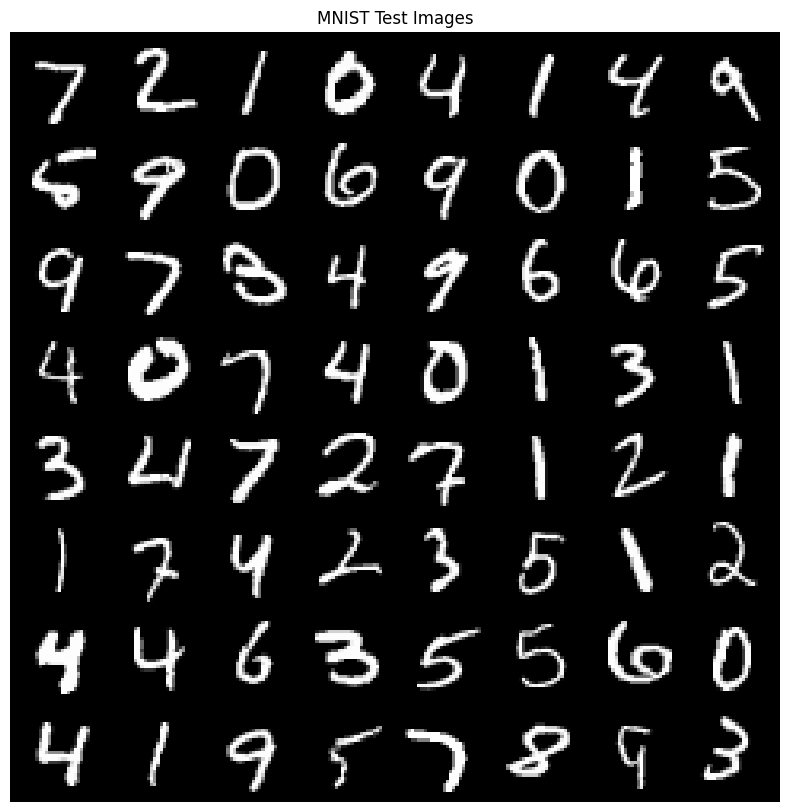

Labels: [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1 3 4 7 2 7
 1 2 1 1 7 4 2 3 5 1 2 4 4 6 3 5 5 6 0 4 1 9 5 7 8 9 3]


In [57]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import os
import struct


def load_mnist_images(filename):
    """Load MNIST images from an idx3-ubyte file."""
    with open(filename, 'rb') as f:
        # Read the magic number and dimensions of the images
        magic, num_images, rows, cols = struct.unpack(">IIII", f.read(16))
        # Read the image data
        images = np.fromfile(f, dtype=np.uint8).reshape(num_images, 1, rows, cols)
        # Normalize the pixel values to [0, 1]
        return images / 255.0

def load_mnist_labels(filename):
    """Load MNIST labels from an idx1-ubyte file."""
    with open(filename, 'rb') as f:
        # Read the magic number and number of labels
        magic, num_labels = struct.unpack(">II", f.read(8))
        # Read the label data
        labels = np.fromfile(f, dtype=np.uint8)
        return labels

def load_test_data():
    """Load the MNIST test data from idx3-ubyte and idx1-ubyte files."""
    # Load images and labels from the files
    images = load_mnist_images('mnist/t10k-images.idx3-ubyte')
    labels = load_mnist_labels('mnist/t10k-labels.idx1-ubyte')
    
    # Convert them to PyTorch tensors
    x_test_tensor = torch.tensor(images, dtype=torch.float32)
    y_test_tensor = torch.tensor(labels, dtype=torch.long)

    # Create a TensorDataset and DataLoader
    test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    
    return test_loader
# Function to visualize images and their labels
def visualize_test_loader(test_loader):
    # Get a batch of test data
    data_iter = iter(test_loader)
    images, labels = next(data_iter)

    # Ensure the images are in the shape (batch_size, 1, height, width) for make_grid
    # They are already in this format, so no need to apply squeeze(1)
    
    # Create a grid of 8x8 images
    img_grid = make_grid(images[:64], nrow=8, normalize=True)

    # Plot the images - permute the dimensions to (height, width, channels)
    plt.figure(figsize=(10, 10))
    plt.imshow(img_grid.permute(1, 2, 0).numpy(), cmap='gray')
    plt.title('MNIST Test Images')
    plt.axis('off')
    plt.show()

    # Print corresponding labels
    print("Labels:", labels[:64].numpy())
test_loader = load_test_data()

# Visualize the test data
visualize_test_loader(test_loader)

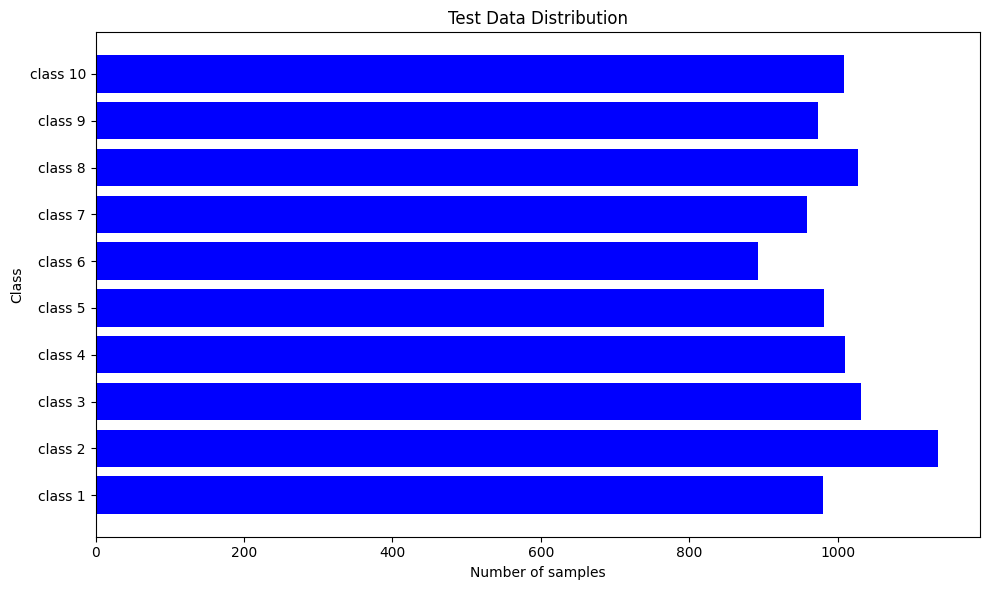

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import os

def load_test_data(test_dir):
    """Load the saved test data."""
    x_data = np.load(os.path.join(test_dir, 'x_test.npy'))
    y_data = np.load(os.path.join(test_dir, 'y_test.npy'))
    return x_data, y_data

def calculate_test_distribution(test_dir):
    """Calculate the class distribution for the test data."""
    _, y_test = load_test_data(test_dir)
    
    # Count the number of samples per class
    classes, counts = np.unique(y_test, return_counts=True)
    
    # Ensure the distribution list has the correct number of classes
    num_classes = max(classes) + 1  # Assuming classes are zero-indexed
    test_dist = np.zeros(num_classes)
    test_dist[classes] = counts
    
    return test_dist

def plot_test_distribution(test_dist, title="Test Data"):
    """Plot the class distribution of the test data."""
    plt.figure(figsize=(10, 6))
    
    # Plot the class distribution
    classes = [f'class {i+1}' for i in range(len(test_dist))]
    plt.barh(classes, test_dist, color='blue')
    
    plt.xlabel('Number of samples')
    plt.ylabel('Class')
    plt.title(f'{title} Distribution')
    plt.tight_layout()
    plt.show()

# Example usage to visualize test distribution
test_data_dir = 'dataset/test'  # Path to test data
test_distribution = calculate_test_distribution(test_data_dir)

# Plot test distribution
plot_test_distribution(test_distribution, title="Test Data")

In [59]:
!ls

README.md           dataloaders.py      model.py            visual_runner.ipynb
__pycache__         dataset             server.py
client.py           mnist               train.py


# Old Code

Root client data saved in 'dataset/root_client'.
Data for each client saved in 'dataset/clients' using IID distribution.


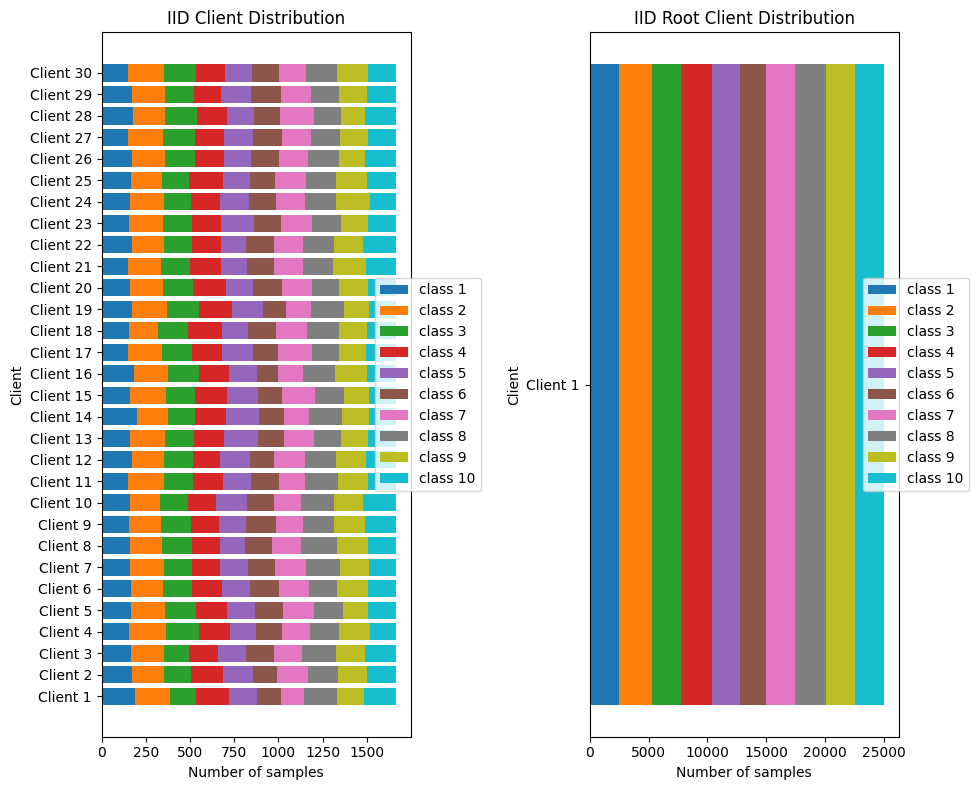

In [24]:
import os
import numpy as np
import torch
import random
import matplotlib.pyplot as plt

# Function to compute class distributions for a set of client data
def compute_class_distributions(client_data, num_classes=10):
    distributions = []
    for x_client, y_client in client_data:
        class_counts = np.bincount(y_client, minlength=num_classes)
        distributions.append(class_counts)
    return np.array(distributions).T  # Transpose to get a list of class-wise distributions

# Function to create and save data splits (IID or random)
def create_client_splits(x_data, y_data, num_clients, distribution='iid'):
    client_data = []
    num_samples = len(x_data)
    indices = list(range(num_samples))

    if distribution == 'iid':
        # IID split: Each client gets an equal share of the data
        random.shuffle(indices)
        split_size = num_samples // num_clients
        for i in range(num_clients):
            start_idx = i * split_size
            end_idx = (i + 1) * split_size
            client_indices = indices[start_idx:end_idx]
            client_data.append((x_data[client_indices], y_data[client_indices]))
    else:
        # Non-IID split: Random class assignment per client
        unique_classes = np.unique(y_data)
        class_indices = {cls: np.where(y_data == cls)[0].tolist() for cls in unique_classes}

        for i in range(num_clients):
            client_indices = []
            for cls in unique_classes:
                num_class_samples = random.randint(0, len(class_indices[cls]) // num_clients)
                selected_indices = random.sample(class_indices[cls], num_class_samples)
                client_indices.extend(selected_indices)

                # Remove the selected indices to avoid repeating
                class_indices[cls] = list(set(class_indices[cls]) - set(selected_indices))

            client_data.append((x_data[client_indices], y_data[client_indices]))

    return client_data

# Save the split data for each client as .npy files
def save_client_data(client_data, save_dir, distribution):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    for i, (x_client, y_client) in enumerate(client_data):
        client_dir = os.path.join(save_dir, f'client_{i+1}')
        if not os.path.exists(client_dir):
            os.makedirs(client_dir)

        np.save(os.path.join(client_dir, 'x_data.npy'), x_client)
        np.save(os.path.join(client_dir, 'y_data.npy'), y_client)

    print(f"Data for each client saved in '{save_dir}' using {distribution.upper()} distribution.")

# Save root client data as .npy files
def save_root_client_data(x_root, y_root, save_dir):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    np.save(os.path.join(save_dir, 'x_data.npy'), x_root)
    np.save(os.path.join(save_dir, 'y_data.npy'), y_root)

    print(f"Root client data saved in '{save_dir}'.")

# Function to split data for root client (50% IID)
def create_root_split(x_data, y_data, root_percentage=0.5):
    num_samples = len(x_data)
    indices = list(range(num_samples))
    random.shuffle(indices)

    root_size = int(root_percentage * num_samples)
    root_indices = indices[:root_size]

    x_root = x_data[root_indices]
    y_root = y_data[root_indices]

    return x_root, y_root

# Function to create and save splits for clients and root client
def create_and_save_splits(x_train, y_train, num_clients=10, distribution='iid'):
    # Create root split (50% of the data, perfectly IID)
    x_root, y_root = create_root_split(x_train, y_train)

    # Save root client data
    root_save_dir = 'dataset/root_client'
    save_root_client_data(x_root, y_root, root_save_dir)

    # Create dataset splits for other clients
    client_data = create_client_splits(x_train, y_train, num_clients, distribution=distribution)

    # Save the splits into the 'dataset' folder
    client_save_dir = 'dataset/clients'
    save_client_data(client_data, client_save_dir, distribution)

    # Compute class distributions for visualization
    return compute_class_distributions(client_data), compute_class_distributions([(x_root, y_root)])

# Visualization code (as provided)
def plot_distributions(client_dist, root_dist, num_clients, title):
    plt.figure(figsize=(10, 8))

    # Plot client distribution
    plt.subplot(1, 2, 1)
    plot_sample_stats(client_dist, num_clients)
    plt.title(f'{title} Client Distribution')

    # Plot root client distribution
    plt.subplot(1, 2, 2)
    plot_sample_stats(root_dist, 1)
    plt.title(f'{title} Root Client Distribution')

    plt.tight_layout()
    plt.show()

def plot_sample_stats(dist, num_clients):
    classes = [f'class {i+1}' for i in range(len(dist))]
    for i in range(len(classes)):
        left = sum(dist[j][:num_clients] for j in range(i))
        plt.barh(range(num_clients), dist[i][:num_clients], left=left, label=classes[i])
    plt.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))
    plt.yticks(range(num_clients), [f'Client {i+1}' for i in range(num_clients)])
    plt.xlabel('Number of samples')
    plt.ylabel('Client')

# Example Usage:

# Load the dataset (assuming x_train_tensor and y_train_tensor are already loaded as tensors)
x_train_numpy = x_train  # Convert tensors to numpy for saving as .npy
y_train_numpy = y_train

num_clients = 30
distribution_type = 'iid'  # Change to 'random' for random (non-IID) distribution

# Create and save splits based on the chosen distribution type
client_distributions, root_distribution = create_and_save_splits(x_train_numpy, y_train_numpy, num_clients=num_clients, distribution=distribution_type)

# Plot the distributions
plot_distributions(client_distributions, root_distribution, num_clients, distribution_type.upper())